In [1]:
# Carga de paquetes necesarios para graficar
!pip install geopandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import requests
import io

from template_funciones import *


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('datos_museos/export.geojson')
barrios = gpd.read_file('datos_museos/barrios.geojson')

## Visualización

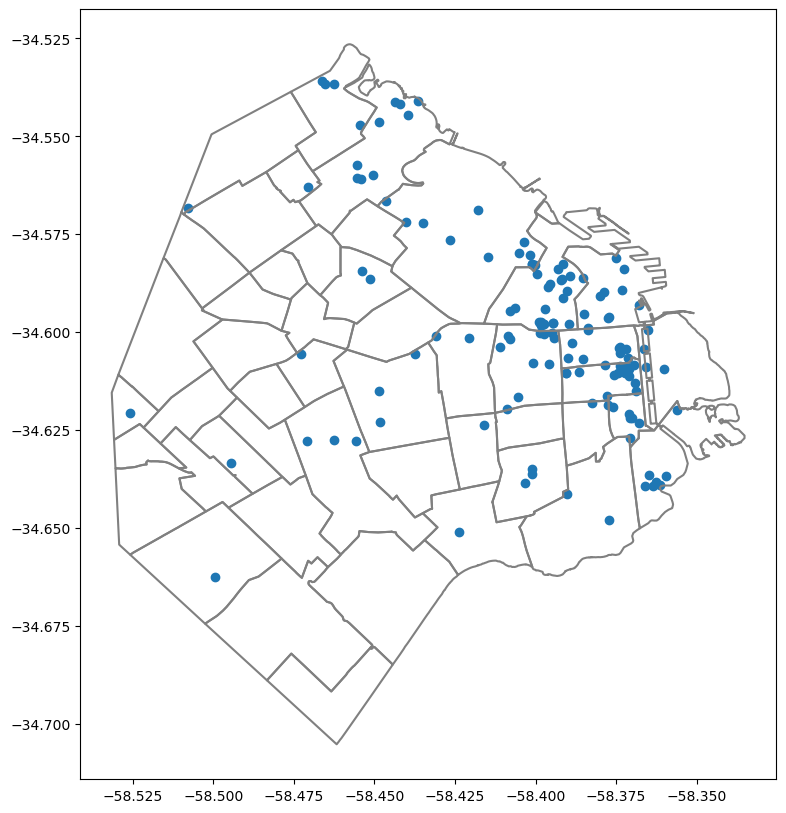

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)
plt.show()

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

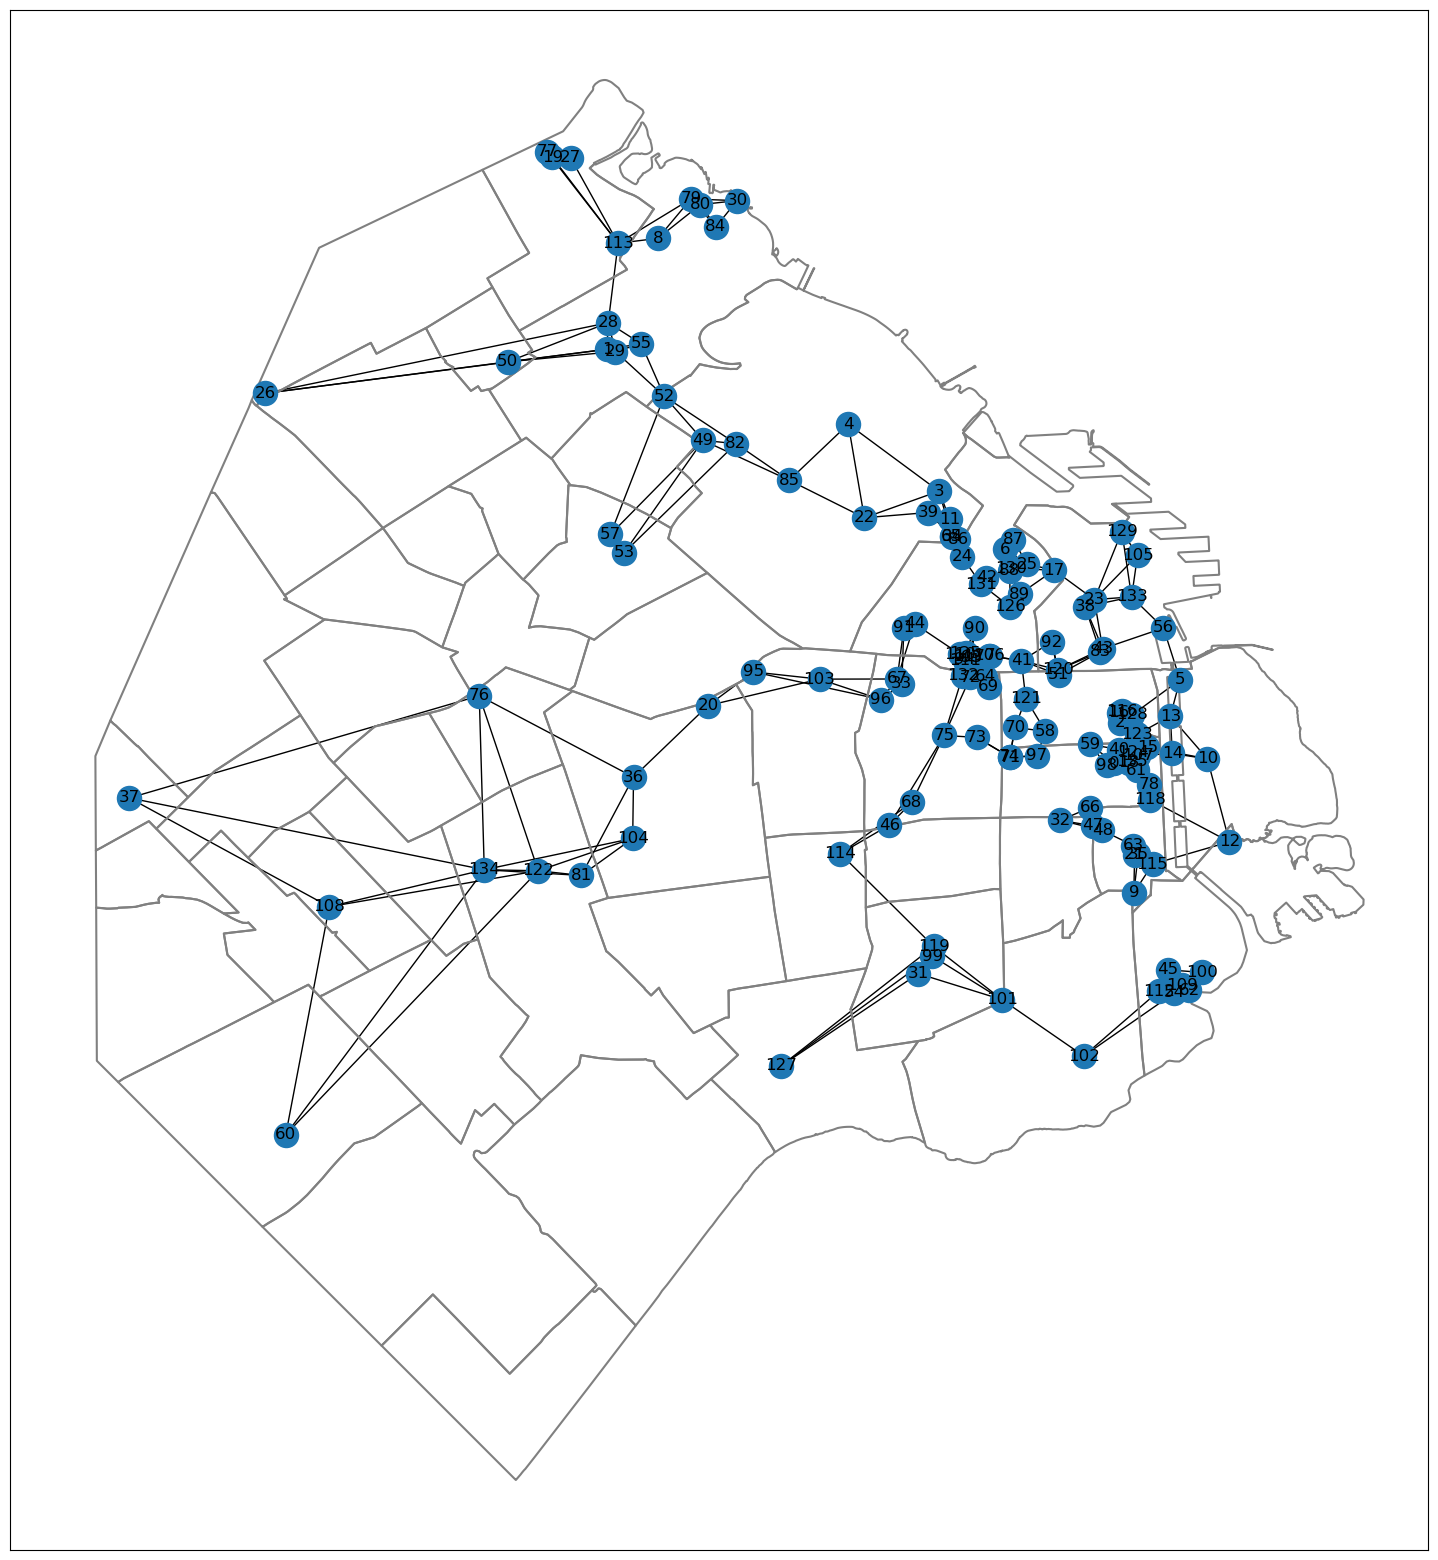

In [7]:
fig, ax = plt.subplots(figsize=(20, 20)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

In [8]:
!pip install geopandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import requests
import io
import json

from template_funciones import *

museos = gpd.read_file('datos_museos/export.geojson')
barrios = gpd.read_file('datos_museos/barrios.geojson')

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


## Punto 1:

Partimos de la siguiente ecuación:    
**I) p = (1 - $\alpha$)Cp + $\frac{\alpha}{N}$1**  

Queremos demostrar que esta expresión es equivalente a $\frac{N}{\alpha}$(I - (1 - $\alpha$)C)p = 1  



I) $\Leftrightarrow$ p - (1 - $\alpha$)Cp = $\frac{\alpha}{N}$1  

$\Leftrightarrow$ (I - (1 - $\alpha$)C)p = $\frac{\alpha}{N}$1  

$\Leftrightarrow$ $\frac{N}{\alpha}$(I - (1 - $\alpha$)C)p = 1  

$\Leftrightarrow$ Mp = 1, con M = $\frac{N}{\alpha}$(I - (1 - $\alpha$)C)  

Queda asi demostrado lo que se queria verlo que se quería ver.


## Punto 2:


Para que exista una unica solucion al sistema Mp = b, **basta con ver que Dim(Nu(M)) = 0, que es lo mismo que ver que X $\in$ Nu(M) $\rightarrow$ X = 0**  

Vamos a probarlo por absurdo, asumiendo que existe un X tal que X $\in$ Nu(M) y X $\neq$ 0 y llegando a una contradiccion:

$\frac{N}{\alpha}$(I - (1 - $\alpha$)C)X = 0  

$\Leftrightarrow$ (I - (1 - $\alpha$)C)X = 0 (Sabemos N > 0 y $\alpha$ > 0)  

$\Leftrightarrow$ X - (1 - $\alpha$)CX = 0  

$\Leftrightarrow$ (1 - $\alpha$)CX = X

$\Leftrightarrow$ (1 - $\alpha$)$1^{t}$CX = $1^{t}$X (Multiplicar por $1^{t}$ a la izquierda en ambos lados)

$\Leftrightarrow$ (1 - $\alpha$)$1^{t}$X = $1^{t}$X ($1^{t}$C = $1^{t}$ porque C es estocastica)

Dado que $\alpha \neq 1$, resulta trivial ver que esto ocurre $\Leftrightarrow$ X = 0, lo cual contradice nuestra hipotesis de que X $\neq$ 0. 

**Queda demostrado por absurdo que X $\in$ Nu(M) $\rightarrow$ X = 0, por lo tanto, Mp = b tiene solucion unica**

## Punto 3:

### 3a

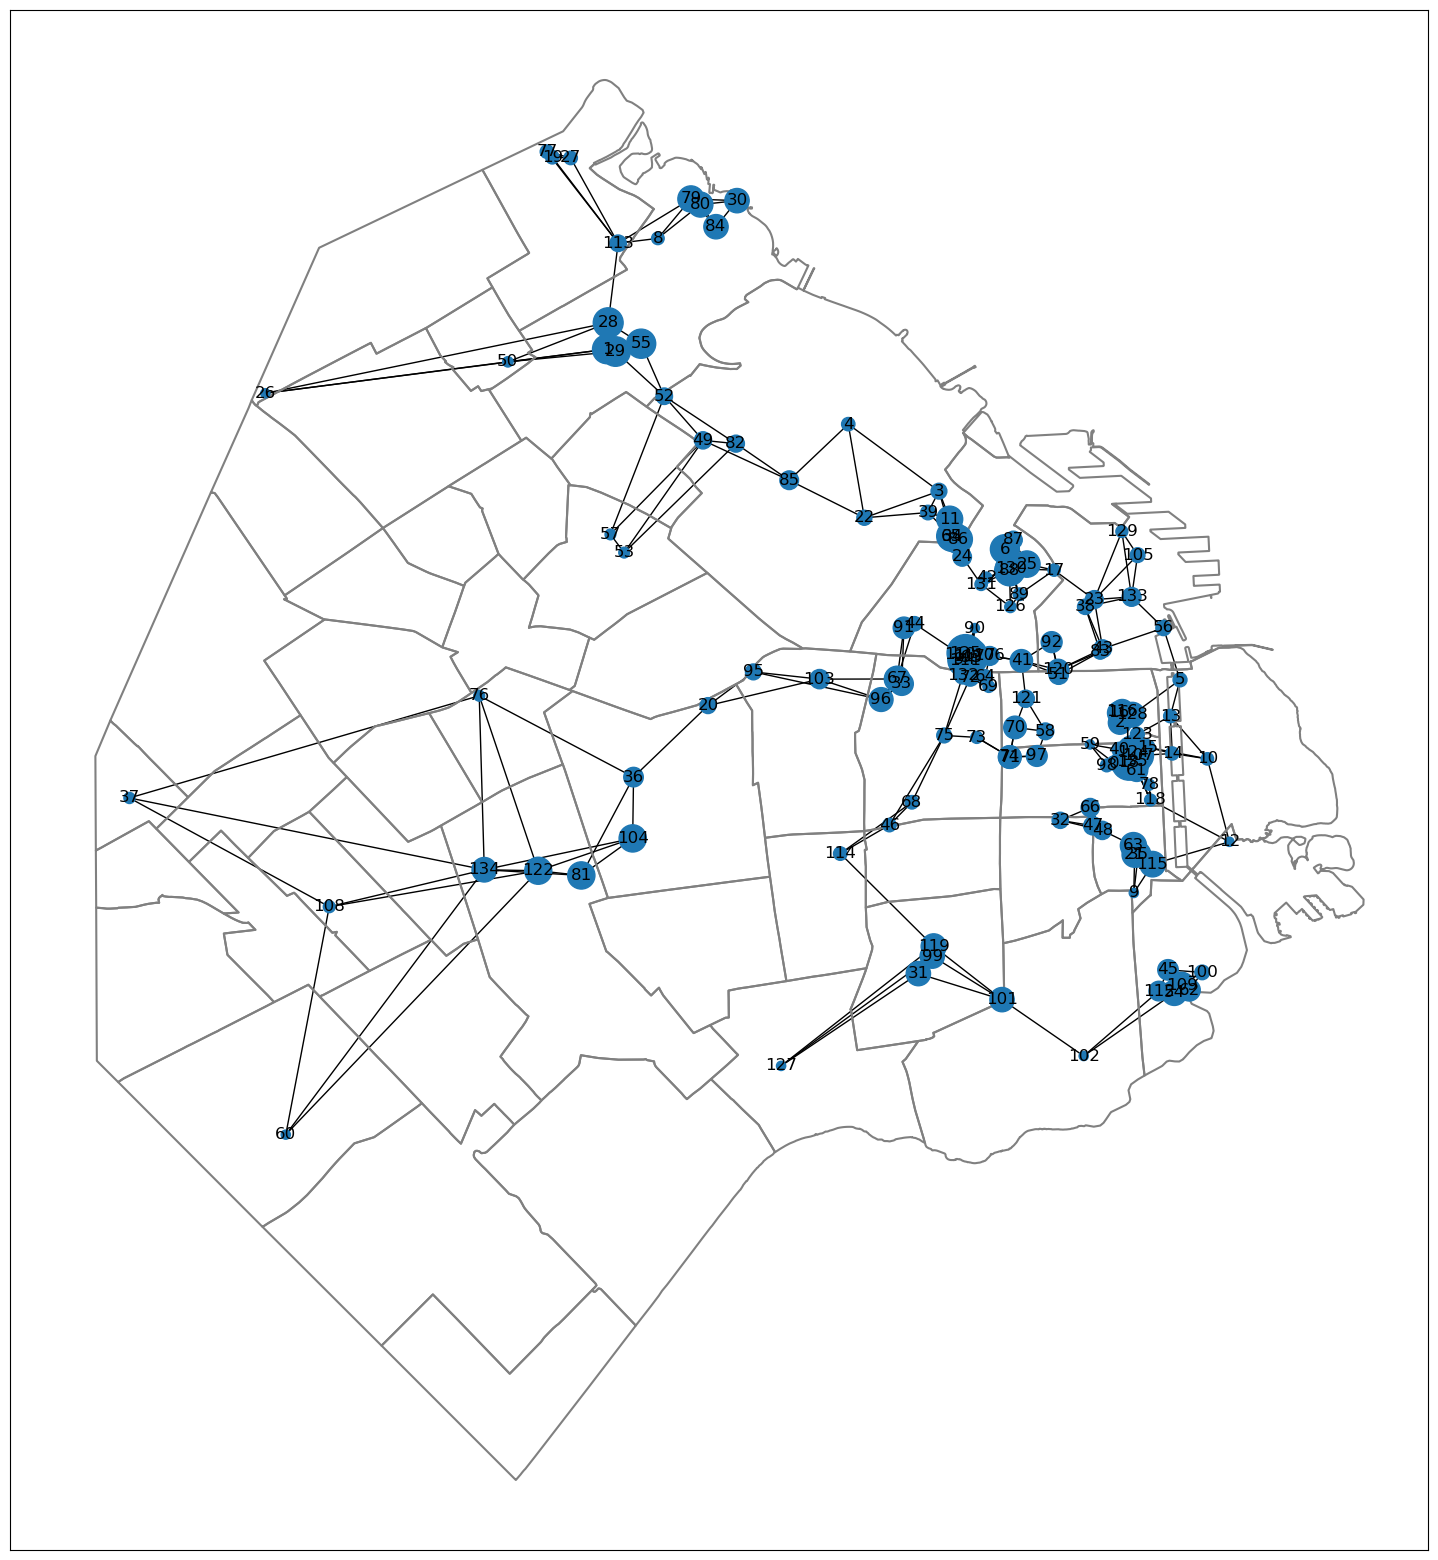

In [9]:
D = construir_matriz_de_distancias(museos)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)
alpha = 1/5

p = calcula_pagerank(A, alpha)

graficar_red(A, museos, barrios, p, network_size=[20, 20], scale=30000, title="")

### 3 - b, c

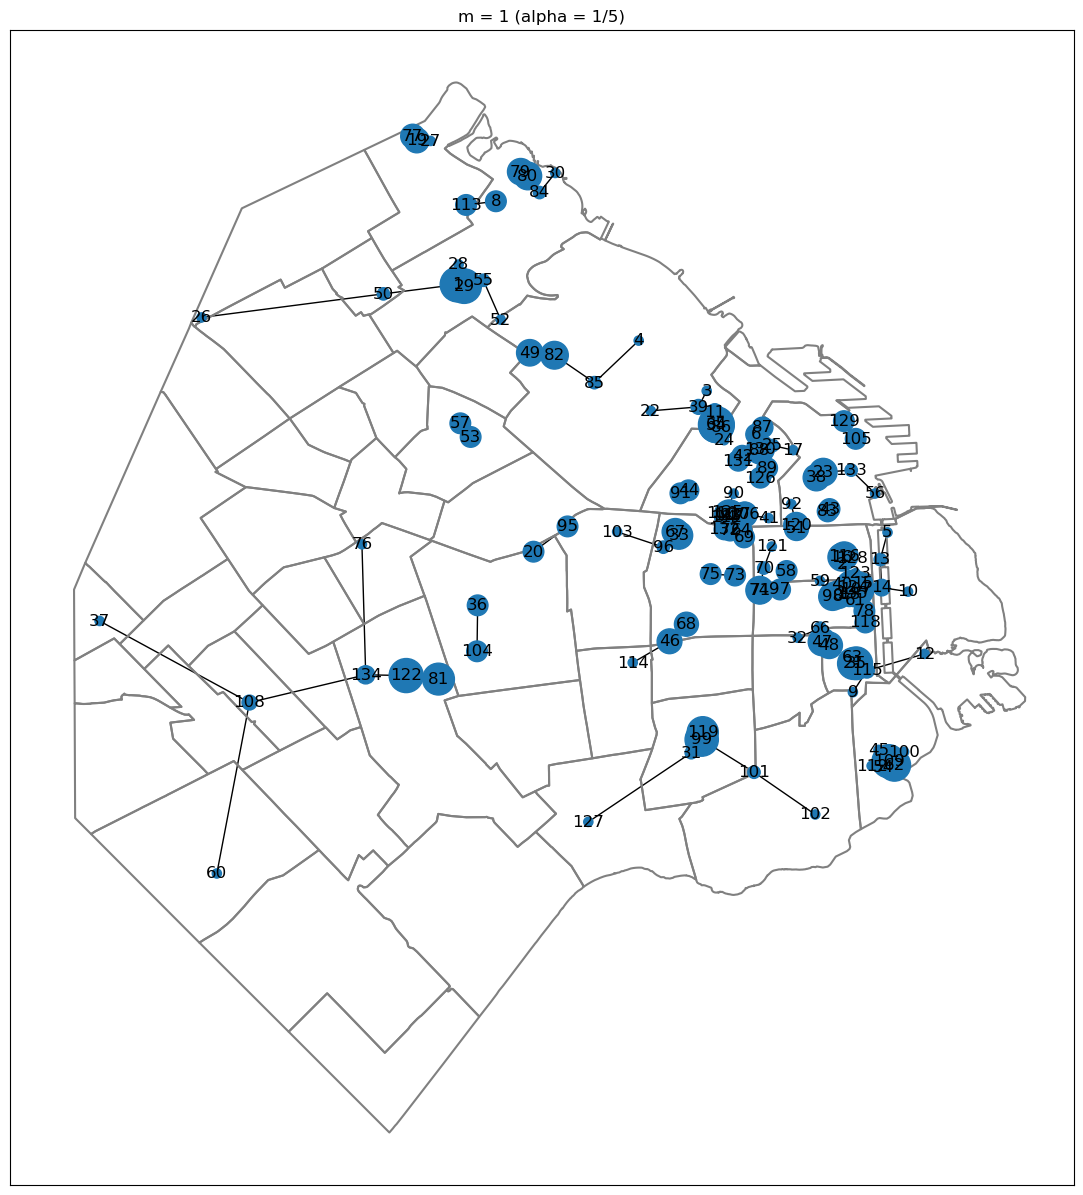

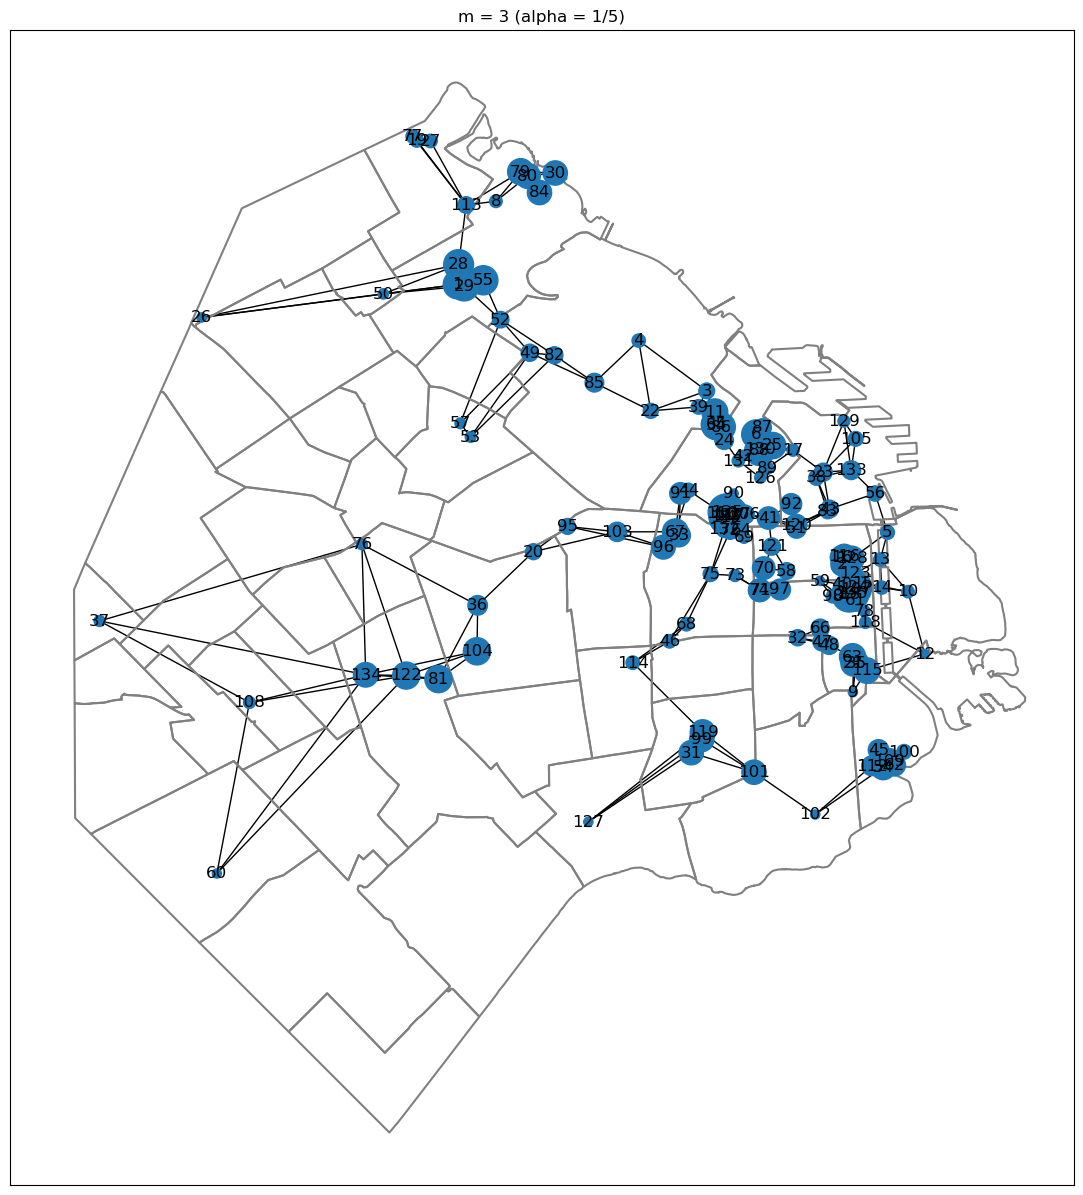

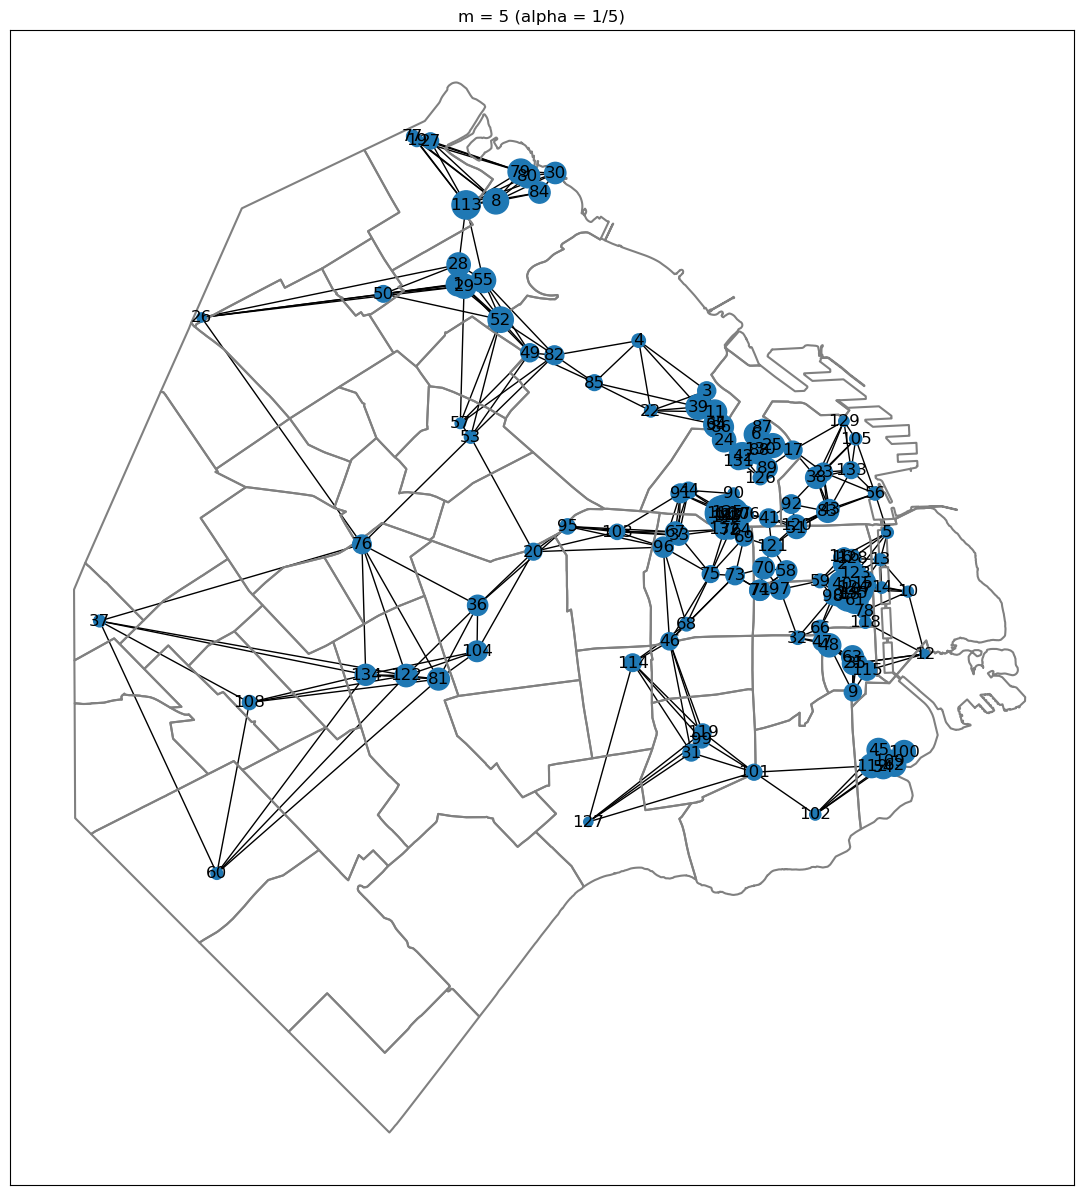

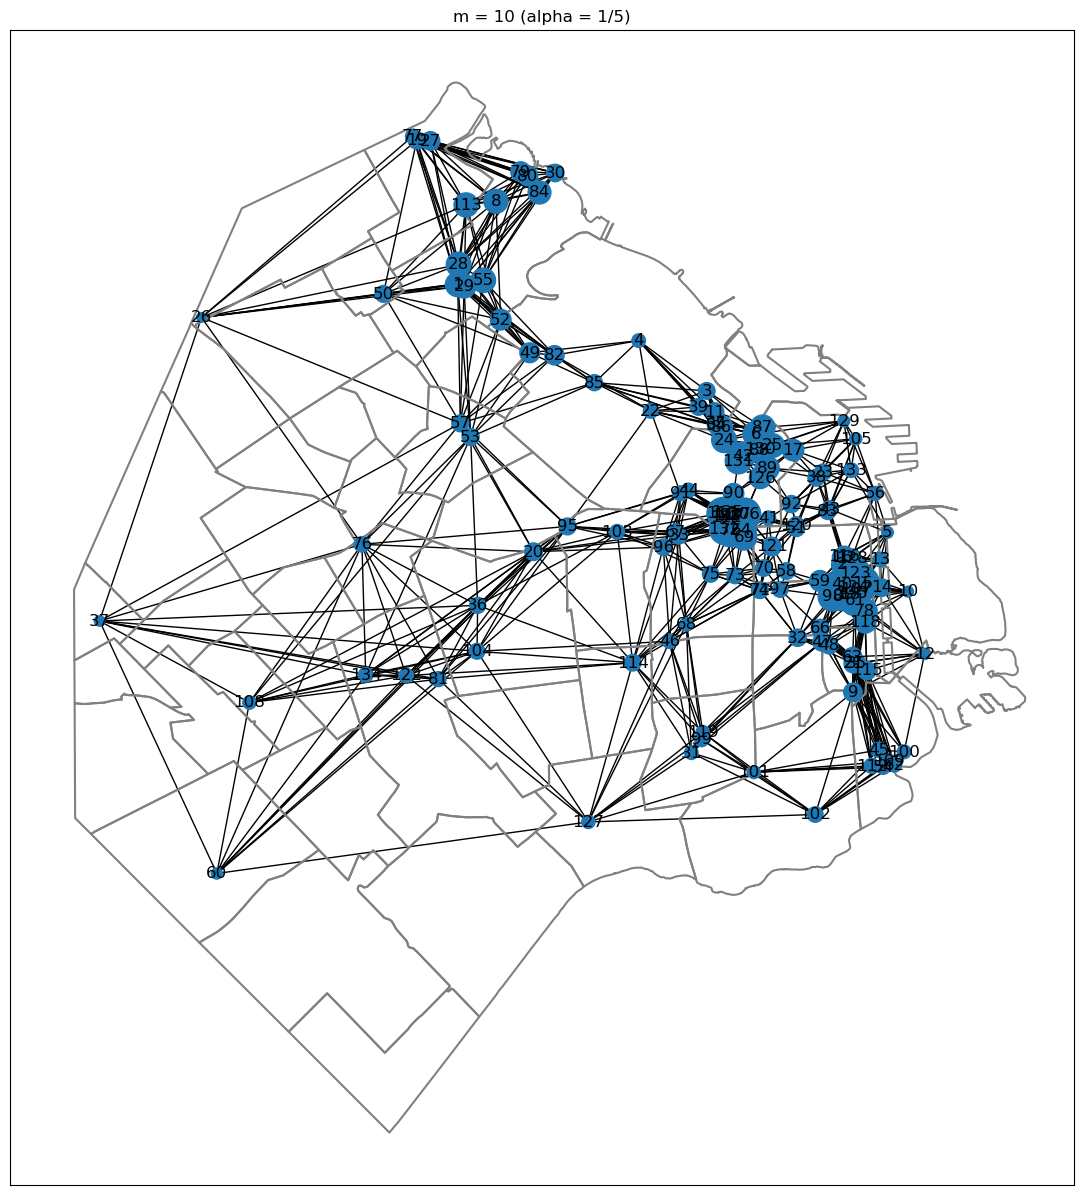

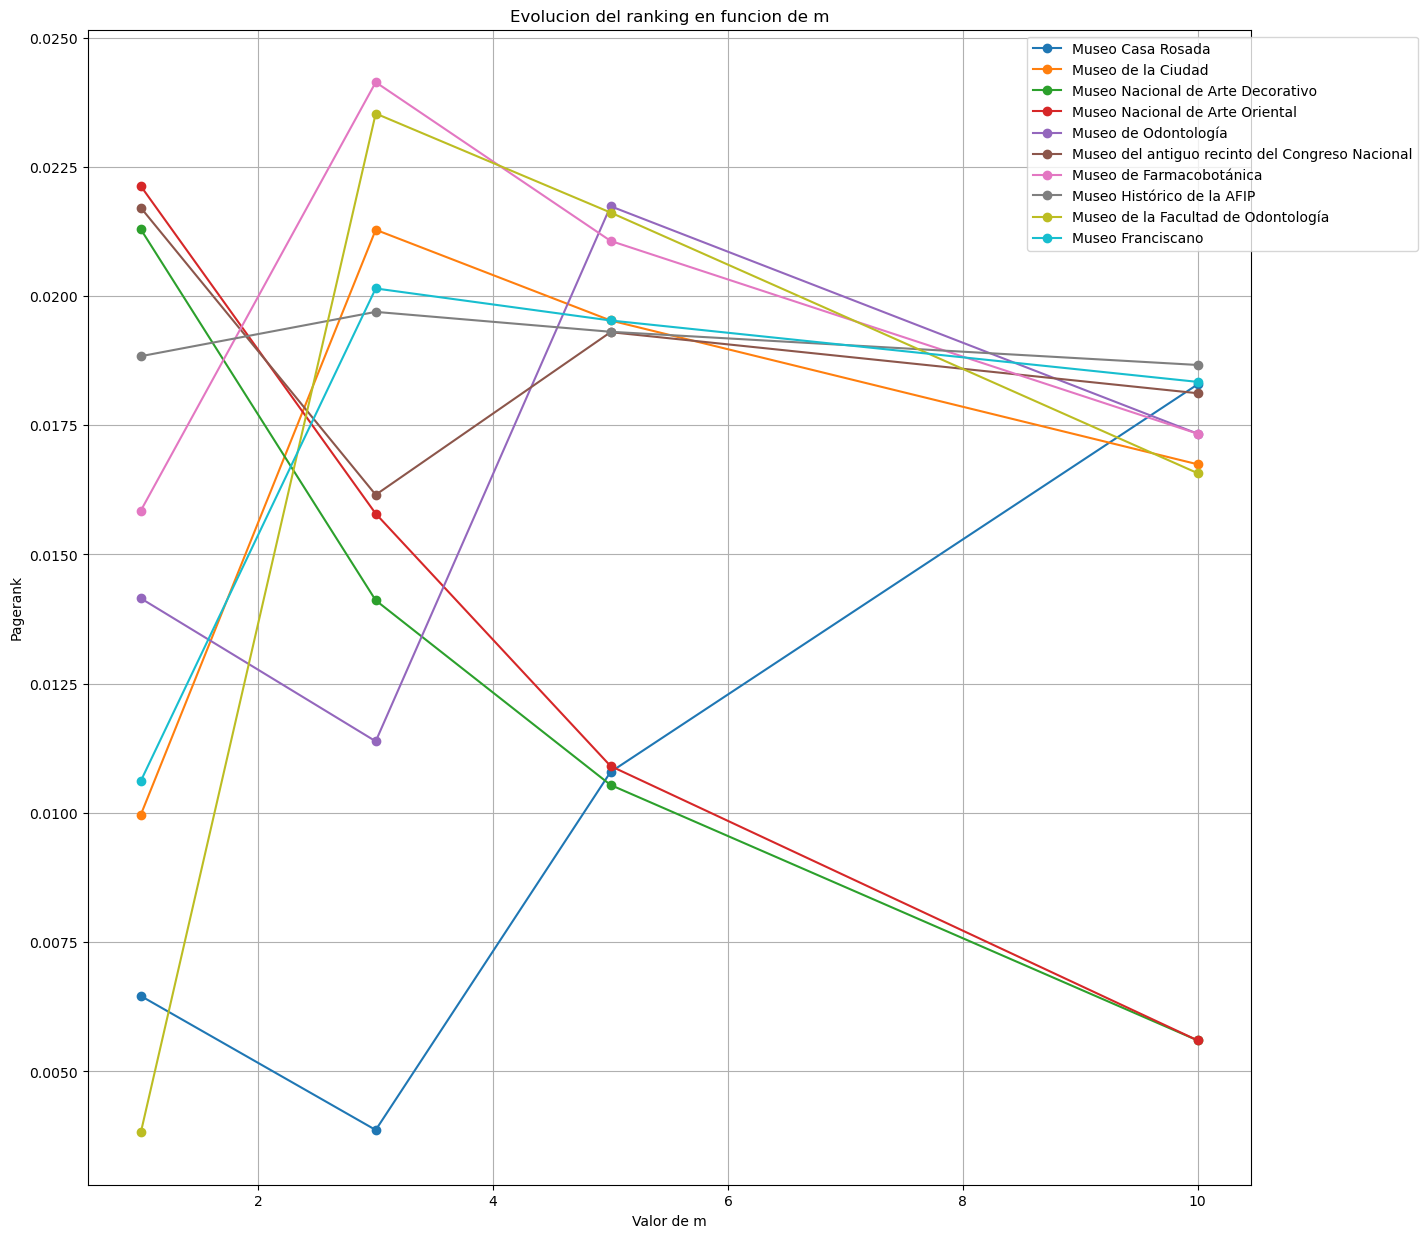

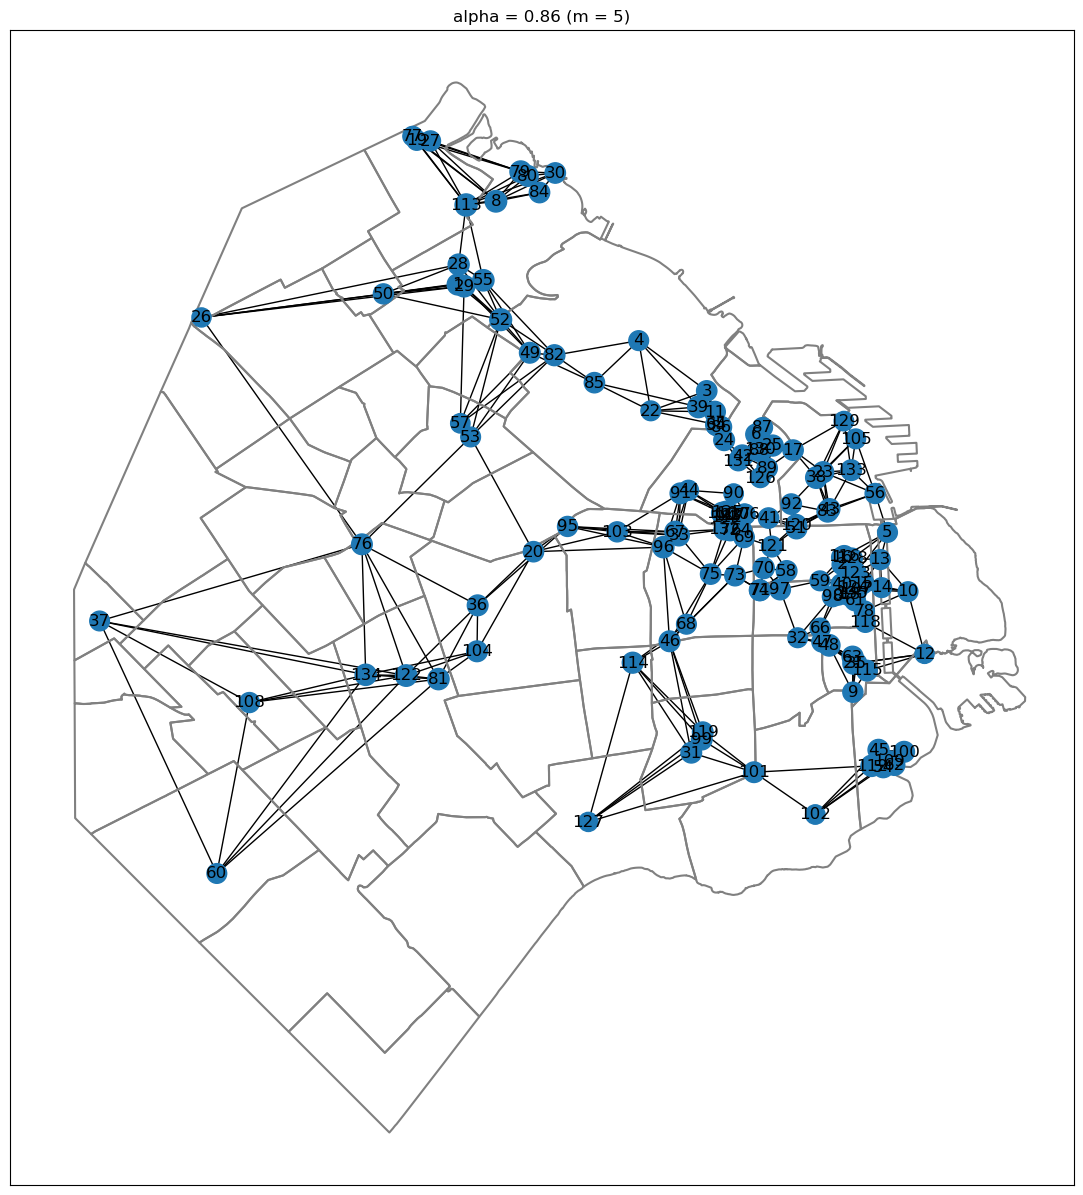

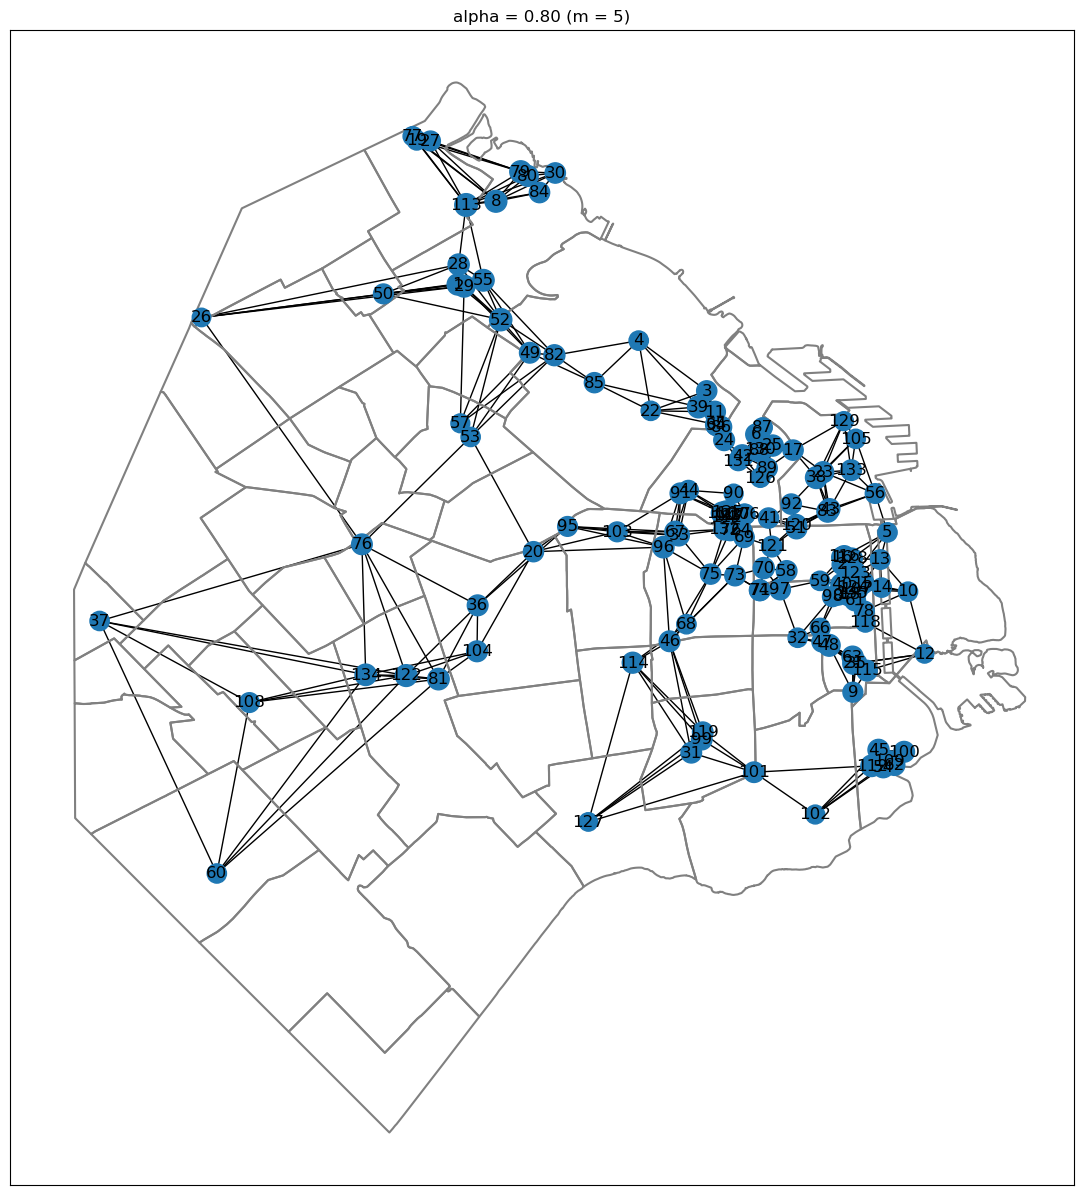

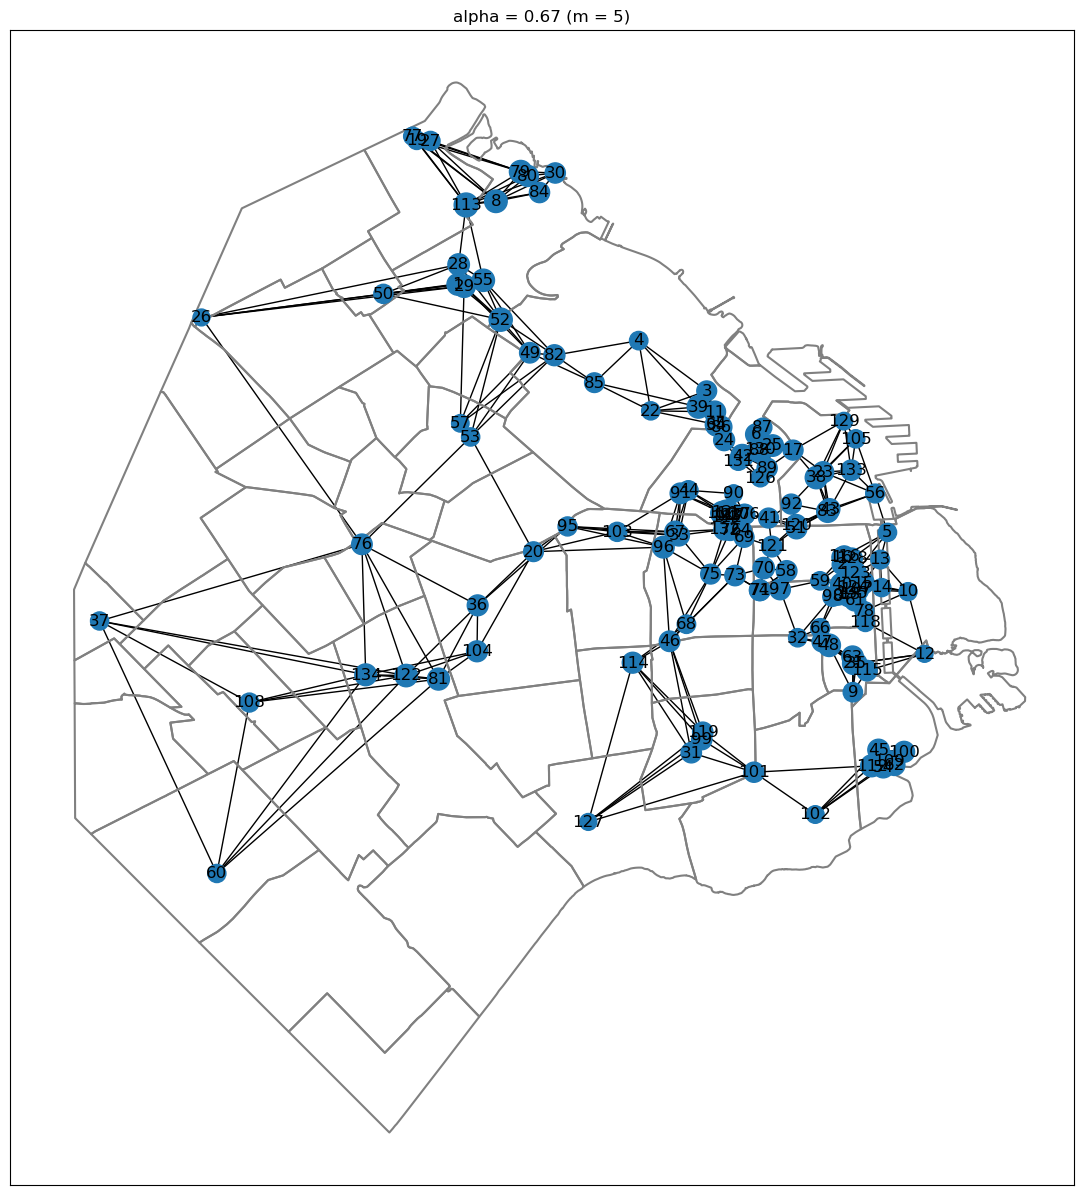

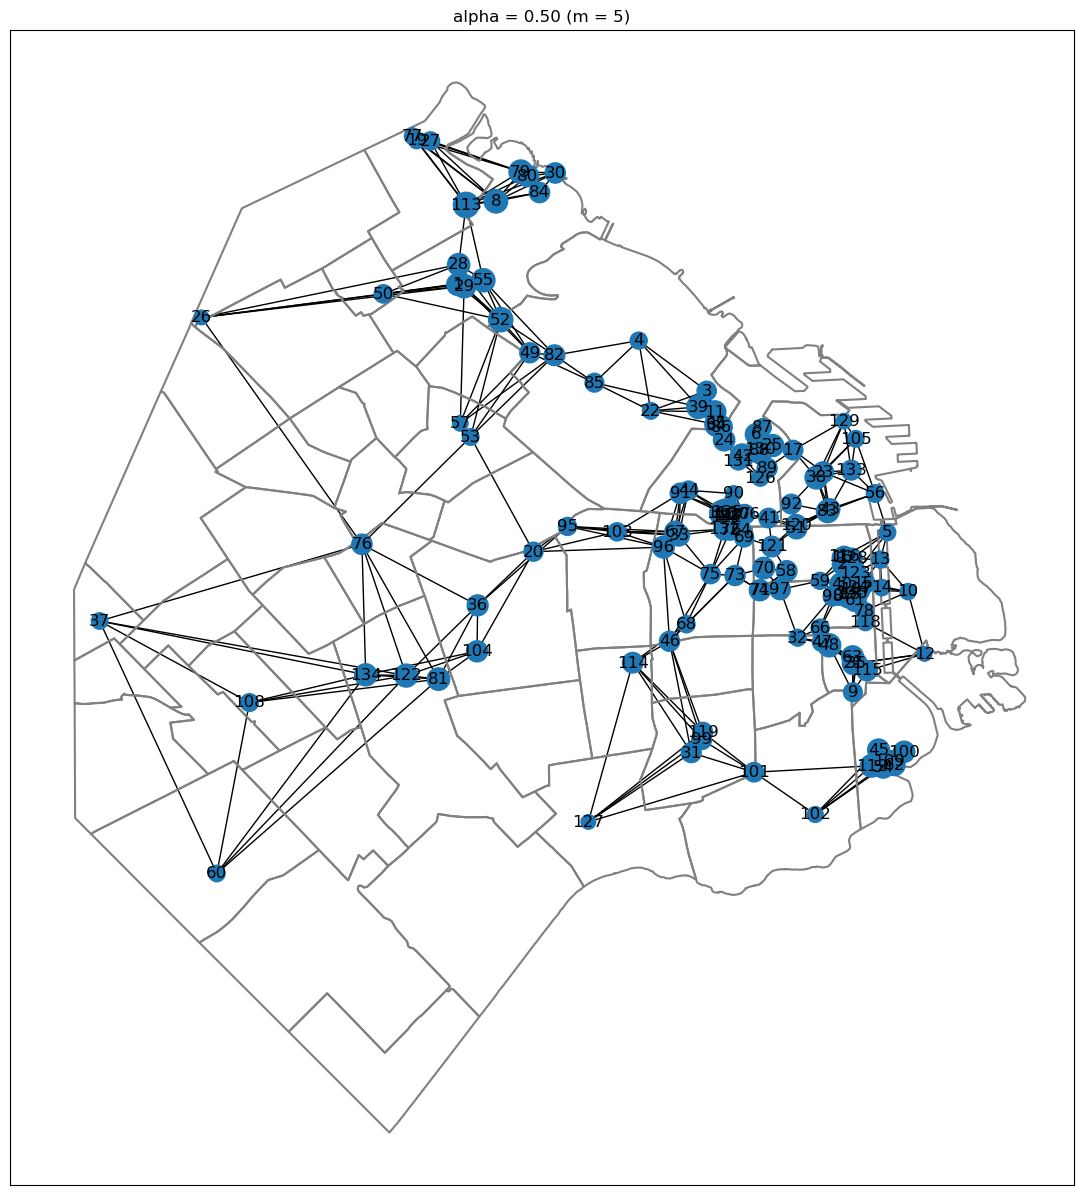

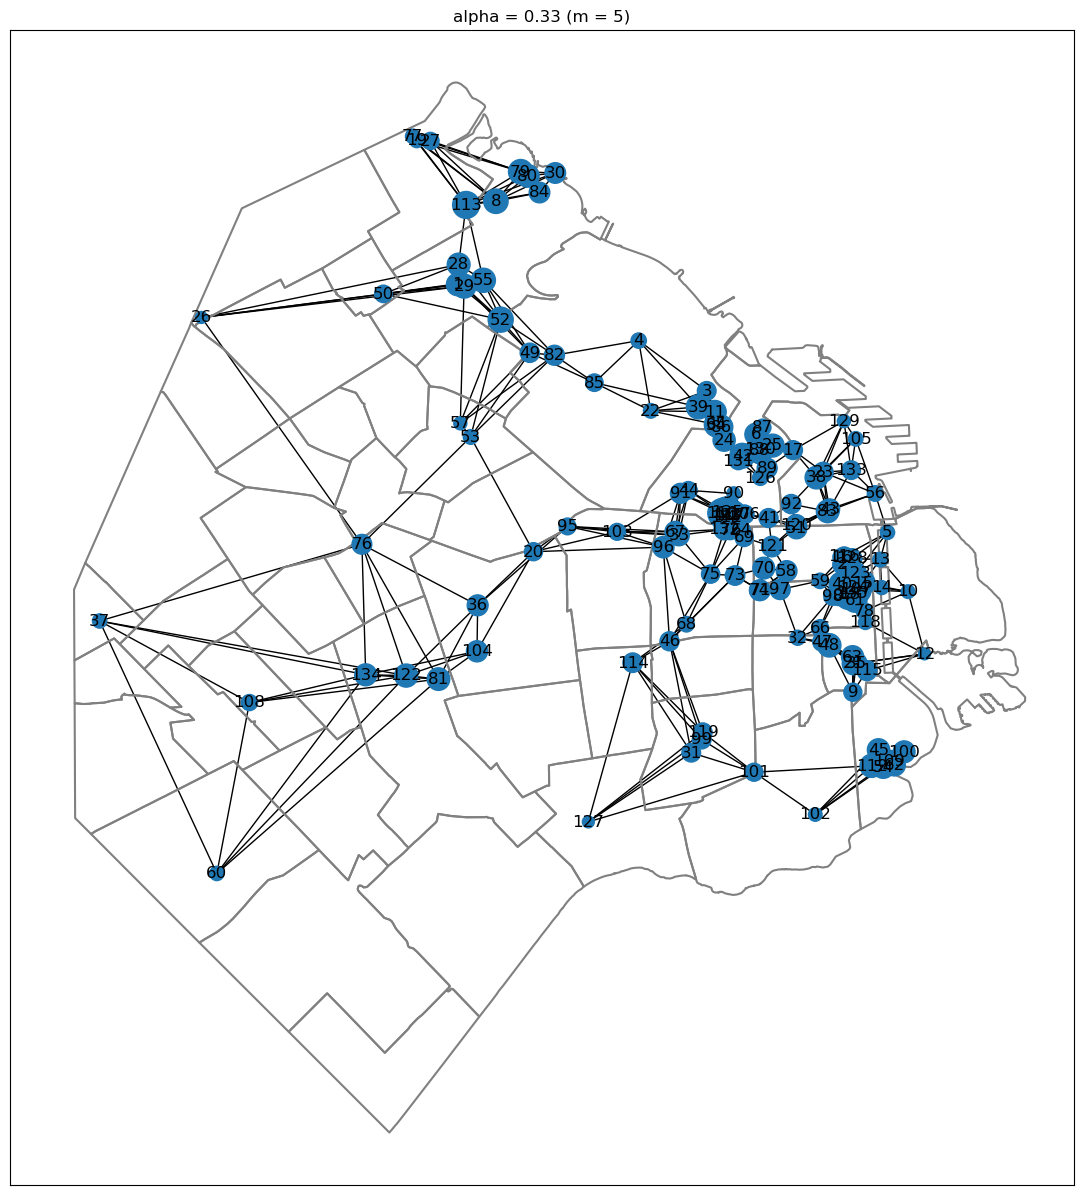

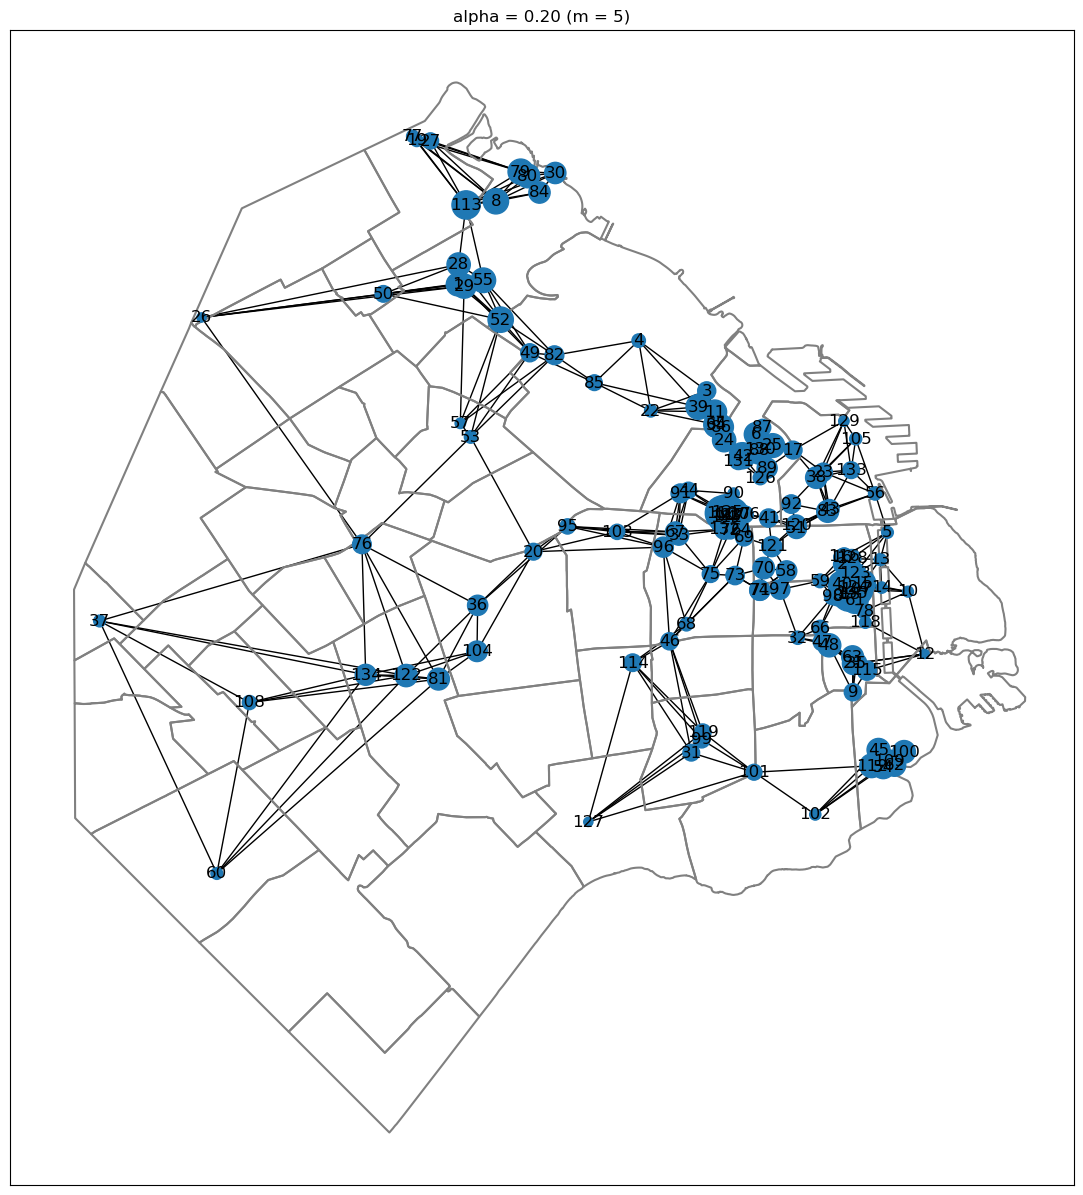

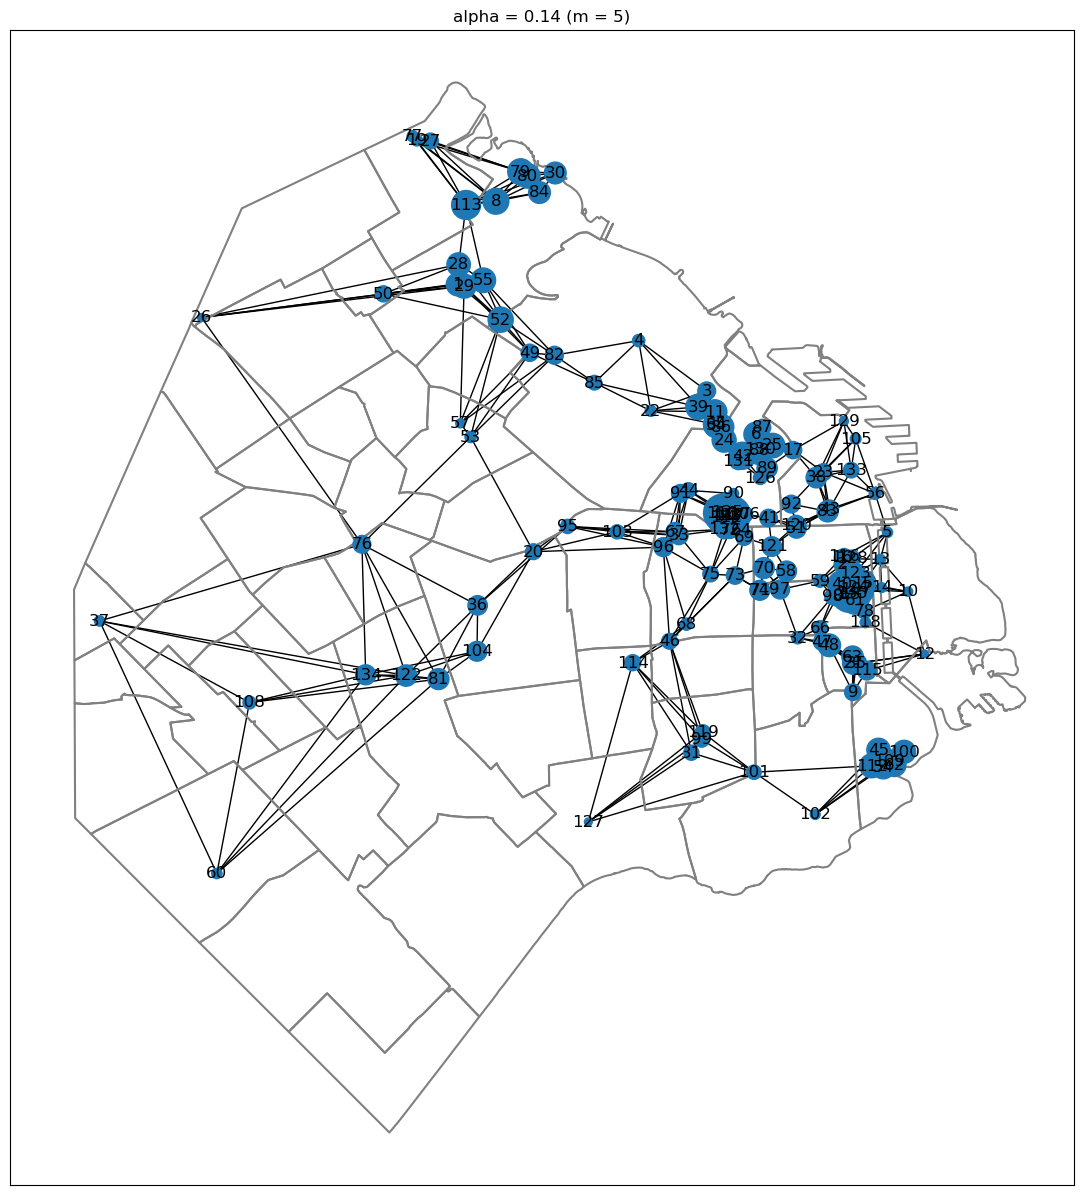

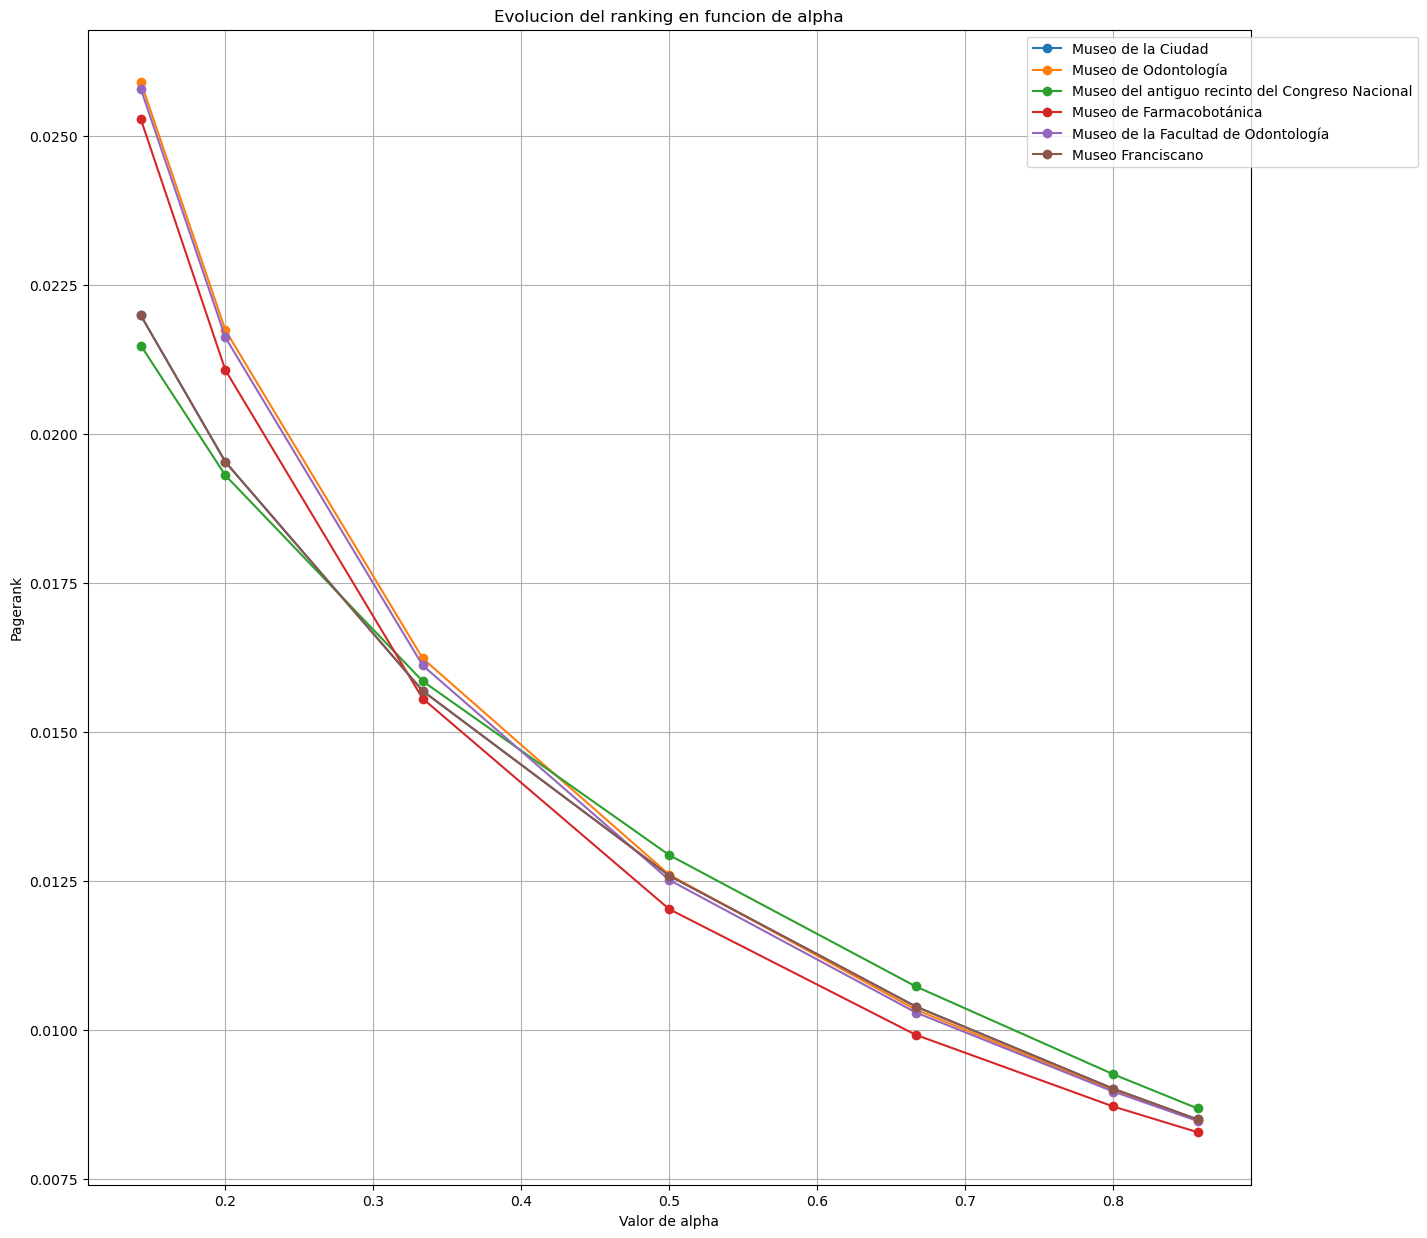

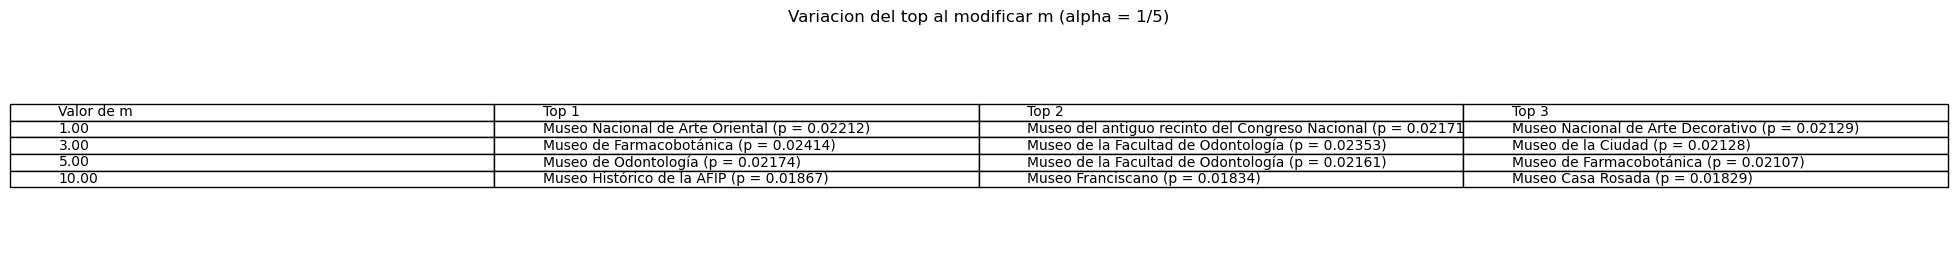

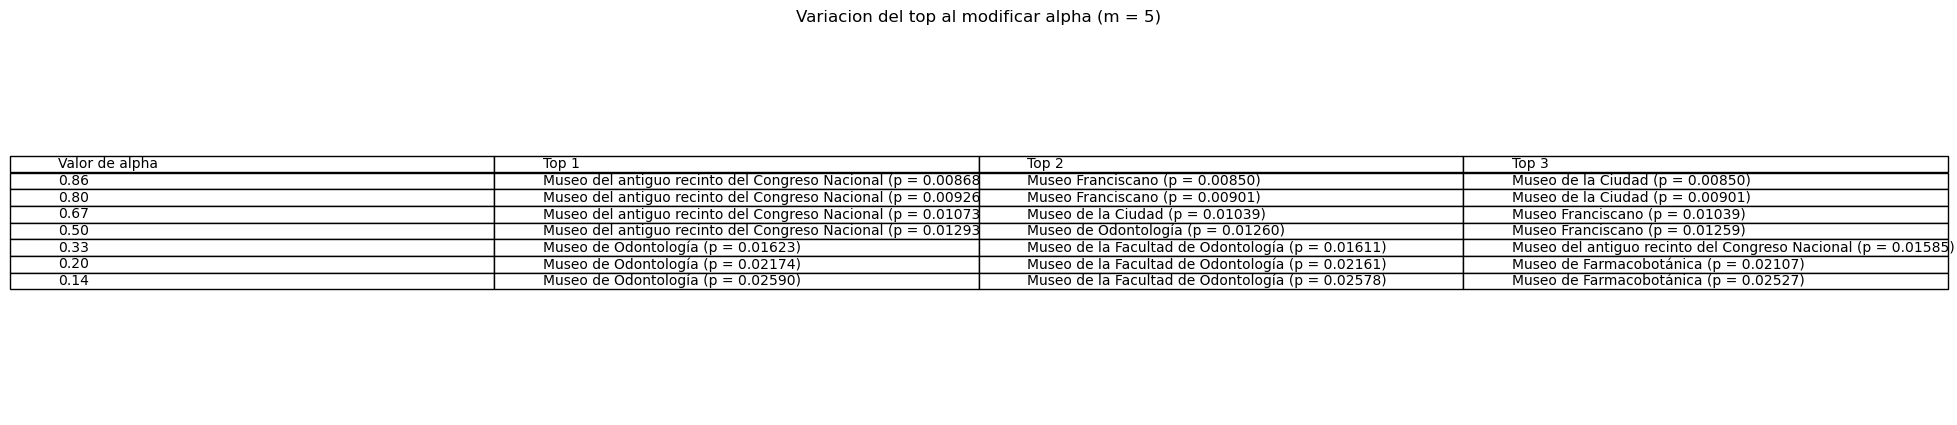

In [10]:
import json

top_ranking_por_m = {}
top_ranking_por_alpha = {}
top_museos = set()
page_ranks = []

valores_de_m = [1,3,5,10]
valores_de_alpha = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]

with open("datos_museos/export.geojson", "r", encoding="utf-8") as f:
    data = json.load(f)

nombres = [f["properties"]["name"] for f in data["features"]]

#Aca hay bastante codigo repetido pero como no es ingenieria de software esperamos sinceramente que sepan disculparnos :)

# Imprimimos los diferentes graficos con las redes del top 3 de museos para alpha = 1/5 y cada variacion de m.
for m in valores_de_m:
    A = construye_adyacencia(D,m)
    p = calcula_pagerank(A, 1/5)
    page_ranks.append(p)
    top_for_current_m = np.argsort(p)[-3:][::-1]
    top_ranking_por_m[m] = list(map(lambda idx: nombres[idx] + f' (p = {p[idx]:.5f})', top_for_current_m))
    top_museos = top_museos | set(top_for_current_m)
    graficar_red(A, museos, barrios, p, network_size=[15, 15], scale=30000, title=f'm = {m} (alpha = 1/5)')

# Representamos la evolucion de los distintos museos en el top del ranking en funcion de m.
construir_grafico_page_rank(
    x_values=valores_de_m, 
    page_ranks=page_ranks,
    x_label="Valor de m",
    title="Evolucion del ranking en funcion de m",
    graph_size=[15,15],
    nombres_museos=nombres,
    top_museos=sorted(top_museos))

top_museos = set()
page_ranks = []

# Imprimimos los diferentes graficos con las redes del top 3 de museos para m = 5 y cada variacion de alpha.
A = construye_adyacencia(D,5)
for alpha in valores_de_alpha:
    p = calcula_pagerank(A, alpha)
    page_ranks.append(p)
    top_for_current_alpha = np.argsort(p)[-3:][::-1]
    top_ranking_por_alpha[alpha] = list(map(lambda idx: nombres[idx] + f' (p = {p[idx]:.5f})', top_for_current_alpha))
    top_museos = top_museos | set(top_for_current_alpha)
    graficar_red(A, museos, barrios, p, network_size=[15, 15], scale=30000, title=f'alpha = {alpha:.2f} (m = 5)')

# Representamos la evolucion de los distintos museos en el top del ranking en funcion de alpha.
construir_grafico_page_rank(
    x_values=valores_de_alpha, 
    page_ranks=page_ranks,
    x_label="Valor de alpha",
    title="Evolucion del ranking en funcion de alpha",
    graph_size=[15,15],
    nombres_museos=nombres,
    top_museos=sorted(top_museos))

# Construimos las tablas para representar la variacion de m y alpha entre el top de museos.

construir_tabla("Variacion del top al modificar m (alpha = 1/5)", [25,3], "Valor de m", top_ranking_por_m)
construir_tabla("Variacion del top al modificar alpha (m = 5)", [25, 5], "Valor de alpha",  top_ranking_por_alpha)

Las posiciones en el ranking no son estables, ya que experimentan cambios al modificar los parámetros *m* y/o *alpha*. Sin embargo, los ajustes en *m* provocan variaciones mucho más bruscas que los cambios en *alpha*.

Se observa claramente que, al aumentar el valor de *m* o disminuir el de *alpha*, los museos ubicados en zonas **céntricas** ganan relevancia de manera notable, en comparación con aquellos situados en zonas periféricas.

A continuación, desglosamos el análisis del comportamiento de las posiciones en el ranking al modificar *m* y *alpha*:

### Comportamiento con respecto a *m*:

Con valores bajos de *m*, los **museos de arte** tienen mayor relevancia. Sin embargo, al aumentar *m* a un valor superior a 1, estos museos desaparecen del ranking.

Para valores intermedios de *m*, los museos de **odontología** y **farmacobotánica** dominan las primeras posiciones. Sin embargo, cuando *m* alcanza un valor de 10, desaparecen de las primeras posiciones.

### Comportamiento con respecto a *alpha*:

A diferencia de *m*, el comportamiento al modificar *alpha* no presenta cambios tan drásticos. Para vaessrior2museos esMa 1/, los **museos del Antiguo Recinto del Congreso Nacional**, el **Museo Franciscano** y el **Museo de la Ciudad** dominan las primeras posiciones. No obstante, al reducir *alpha* por debajo de 1/2, estos museos son completamente desplazados por los de **odontología** y **farmacobotánica**.

Es interesante notar que existen museos cuya relevancia está asociada a redes con **pocas conexiones**. Un claro ejemplo es el **Museo Nacional de Arte Oriental**, que solo ocupa las primeras posiciones cuando *m = 1*. 

Por otro lado, hay museos cuya relevancia crece a medida que **aumenta el número de conexiones**. El **Museo Histórico de la AFIP**, por ejemplo, no apareció en las primeras posiciones hasta que *m* alcanzó el valor de 10.

## Punto 4:

Dado:

- $v \in R^N$, donde $v_i$ representa la cantidad de personas que comenzaron la visita en el museo $i$.
- $C \in R^{N \times N}$, la matriz de transición, donde $C_{ij}$ es la probabilidad de moverse del museo $j$ al museo $i$ en un solo paso.
- $r$, el número total de visitas que cada persona realiza antes de abandonar la red.

Queremos demostrar que el vector $v$ de ingresos iniciales se puede calcular como:

$v = B^{-1} w, \quad \text{con} \quad B = \sum_{k = 0}^{r - 1} C^k.$

Si analizamos la evolución de las visitas, sabemos que:

- En el paso 0 (inicio), la distribución de visitantes es simplemente $v$.
- En el paso 1, la distribución es $Cv$.
- En el paso 2, la distribución es $C^2 v$.
...
- En el paso $k$, la distribución de visitantes es $C^k v$.

Dado que cada persona realiza exactamente $r$ visitas antes de salir de la red, la cantidad total de visitas recibidas por cada museo es la suma de las distribuciones en todos los pasos:

$w = \sum_{k = 0}^{r - 1} C^k v$

Sabiendo que B se define como:

$B = \sum_{k = 0}^{r - 1} C^k$

podemos escribir la ecuación anterior como:

$w = B v$

Tal que nos queda la equivalencia:

$Bv = B(B^{-1})w$
$\Leftrightarrow Bv = w$
$\Leftrightarrow (I + C + C^2 + ... + C^{r-1})v = w$ 

Por lo tanto, sabiendo que la matriz $B$ es invertible, y que entonces podemos despejar $v = B^{-1} w$.

Se prueba la relación buscada.

## Punto 5:

In [1]:
D = construir_matriz_de_distancias(museos)
C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)

# Obtenemos el vector w a partir del archivo "visitas.txt".
with open("datos-museos/visitas.txt", "r") as visitas:
    w = [int(linea.strip()) for linea in visitas]

v = calcular_ecuacion_5(B, w)

# Reducimos la cantidad de decimales mostrados a 0.
np.set_printoptions(precision=0, suppress=True)

print(f"Distribucion de los visitantes en la primera iteracion: {v}")
print(f"Total de visitantes en la red tras completar todas las iteraciones: {np.sum(w)}, Total visitantes en la primera iteracion: {np.sum(v):.0f}")

NameError: name 'construir_matriz_de_distancias' is not defined

## Punto 6:

In [12]:
D = construir_matriz_de_distancias(museos)
C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)

# Obtenemos el vector w a partir del archivo "visitas.txt".
with open("datos-museos/visitas.txt", "r") as visitas:
    w = [int(linea.strip()) for linea in visitas]

cota_superior = acotar_error(B, w, 1.05)
print(f"Cota del error: {(cota_superior * 100):.2f}%")

Cota del error: 56.47%


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

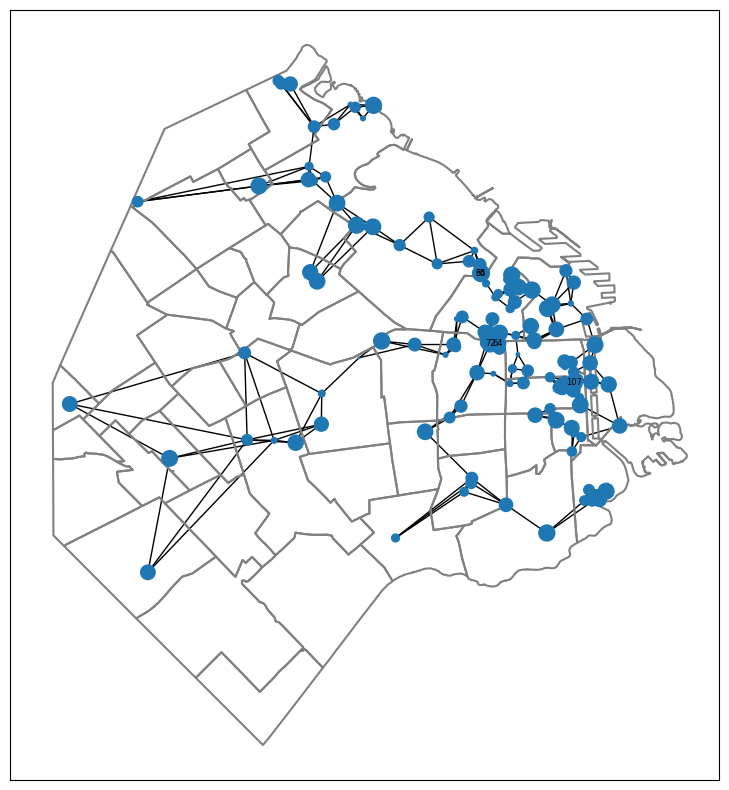

In [13]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres